# 📦 Imports

In [2]:
import pandas as pd
import numpy as np
import joblib
import logging
from typing import List, Dict, Any

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score)

import lightgbm as lgb
from xgboost import XGBClassifier

# Logging config

In [3]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s"
)
logger = logging.getLogger("exo_model_pipeline")

# 📥 Data Loading Helpers

In [4]:
def read_with_fallback(path: str) -> pd.DataFrame:
    """Try reading as comma-separated, fallback to tab-separated if needed."""
    try:
        df = pd.read_csv(path, sep=",", comment="#", low_memory=False)
    except Exception:
        df = pd.read_csv(path, sep="\t", comment="#", low_memory=False)
    if df.shape[1] == 1:  # fallback if single column
        df = pd.read_csv(path, sep="\t", comment="#", low_memory=False)
    logger.info("Loaded %s with shape %s", path, df.shape)
    return df

# 🔧 Utility Functions

In [5]:
def compute_baseline_stats(X: pd.DataFrame) -> Dict[str, Dict[str, float]]:
    """Compute mean/std for each feature for drift checking."""
    stats = {}
    for c in X.columns:
        col = pd.to_numeric(X[c], errors="coerce")
        stats[c] = {
            "mean": float(np.nanmean(col)),
            "std": float(np.nanstd(col)),
            "count": int(np.sum(~np.isnan(col)))
        }
    return stats

In [6]:
def save_artifacts(model: Pipeline, model_path: str,
                   metadata: Dict[str, Any], meta_path: str):
    joblib.dump(model, model_path)
    joblib.dump(metadata, meta_path)
    logger.info("Artifacts saved to %s and %s", model_path, meta_path)

# ⚙️ Build Pipeline

In [8]:
def build_pipeline(n_jobs: int = -1) -> Pipeline:
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    estimators = [
        ("rf", RandomForestClassifier(n_estimators=200, random_state=42)),
        ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)),
        ("lgbm", lgb.LGBMClassifier(random_state=42))
    ]

    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=500, multi_class="multinomial"),
        cv=5,
        n_jobs=n_jobs
    )

    return Pipeline(steps=[("preprocessor", numeric_transformer),
                           ("clf", stacking_clf)])

# 📊 Train + Evaluate

In [9]:
def train_and_evaluate(X: pd.DataFrame, y: pd.Series,
                       test_size: float = 0.2,
                       random_state: int = 42,
                       cv_folds: int = 5):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    logger.info("Train shape: %s, Test shape: %s", X_train.shape, X_test.shape)

    pipeline = build_pipeline()

    # CV
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv,
                                scoring="accuracy", n_jobs=-1)
    logger.info("CV accuracy: %.4f ± %.4f", cv_scores.mean(), cv_scores.std())

    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision_macro": precision_score(y_test, y_pred, average="macro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "roc_auc_ovr": roc_auc_score(y_test, y_proba, multi_class="ovr"),
        "roc_auc_ovo": roc_auc_score(y_test, y_proba, multi_class="ovo")
    }

    print("\n✅ Holdout Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    print("\n📑 Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    baseline_stats = compute_baseline_stats(X_train)

    return pipeline, metrics, baseline_stats, X_train.columns

# 🚀 Example Usage

In [11]:
koi = read_with_fallback("/content/cumulative_2025.09.24_03.42.53.csv")
toi = read_with_fallback("/content/TOI_2025.09.24_03.43.03.csv")
k2 = read_with_fallback("/content/k2pandc_2025.09.24_03.43.09.csv")

## Label mapping

In [12]:
koi_map = {"CONFIRMED": "CONFIRMED", "CANDIDATE": "CANDIDATE", "FALSE POSITIVE": "FALSE POSITIVE"}
toi_map = {"PC": "CANDIDATE", "CP": "CONFIRMED", "KP": "CONFIRMED", "FP": "FALSE POSITIVE"}
k2_map = {"CONFIRMED": "CONFIRMED", "CANDIDATE": "CANDIDATE", "FALSE POSITIVE": "FALSE POSITIVE"}

In [13]:
koi["label"] = koi["koi_disposition"].map(koi_map)
toi["label"] = toi["tfopwg_disp"].map(toi_map)
k2["label"] = k2["disposition"].map(k2_map)

## Drop unmapped

In [14]:
koi = koi.dropna(subset=["label"])
toi = toi.dropna(subset=["label"])
k2 = k2.dropna(subset=["label"])

## Merge

In [15]:
df = pd.concat([koi, toi, k2], ignore_index=True)
X = df.select_dtypes(include=[np.number])
y = df["label"]

## Train + evaluate

In [16]:
pipeline, metrics, baseline_stats, feature_cols = train_and_evaluate(X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['koi_teq_err1' 'koi_teq_err2']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['koi_teq_err1' 'koi_teq_err2']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/lo


✅ Holdout Metrics:
accuracy: 0.8932
precision_macro: 0.8988
recall_macro: 0.8929
f1_macro: 0.8955
roc_auc_ovr: 0.9779
roc_auc_ovo: 0.9788

📑 Classification Report:
                precision    recall  f1-score   support

     CANDIDATE     0.8504    0.8960    0.8726      1605
     CONFIRMED     0.9076    0.8817    0.8944      1259
FALSE POSITIVE     0.9383    0.9012    0.9194      1265

      accuracy                         0.8932      4129
     macro avg     0.8988    0.8929    0.8955      4129
  weighted avg     0.8948    0.8932    0.8936      4129

Confusion Matrix:
[[1438  101   66]
 [ 140 1110    9]
 [ 113   12 1140]]


/tmp/ipython-input-669358249.py:7: RuntimeWarning: Mean of empty slice
  "mean": float(np.nanmean(col)),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Save

In [17]:
metadata = {"feature_cols": list(feature_cols),
            "baseline_stats": baseline_stats,
            "metrics": metrics,
            "categories": sorted(y.unique())}
save_artifacts(pipeline, "./exo_model.pkl", metadata, "./exo_meta.pkl")

## Reload + test inference

In [18]:
model, metadata = load_artifacts("./exo_model.pkl", "./exo_meta.pkl")
sample_row = X.iloc[[0]]
pred = model.predict(sample_row)[0]
proba = model.predict_proba(sample_row)[0]
print("\n🔮 Prediction:", pred)
print("Probabilities:", dict(zip(metadata["categories"], proba)))


🔮 Prediction: CONFIRMED
Probabilities: {'CANDIDATE': np.float64(0.01824279918067515), 'CONFIRMED': np.float64(0.9806699098837639), 'FALSE POSITIVE': np.float64(0.0010872909355610064)}


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['koi_teq_err1' 'koi_teq_err2']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['koi_teq_err1' 'koi_teq_err2']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 🔎 Local Explanation using SHAP (single prediction, sample 0)

In [43]:
import shap
import matplotlib.pyplot as plt

In [44]:
lgbm_model = pipeline.named_steps["clf"].named_estimators_["lgbm"]

In [45]:
X_test_transformed = pipeline.named_steps["preprocessor"].transform(X_test)
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['koi_teq_err1' 'koi_teq_err2']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [46]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test_transformed)

In [63]:
sample_idx = 0
sample_data = X_test_transformed[sample_idx, :]
class_names = pipeline.named_steps["clf"].classes_

In [64]:
pred_class_idx = lgbm_model.predict(sample_data.reshape(1, -1))[0]
pred_class_name = class_names[pred_class_idx]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔎 Local SHAP for sample 0, predicted class: CANDIDATE


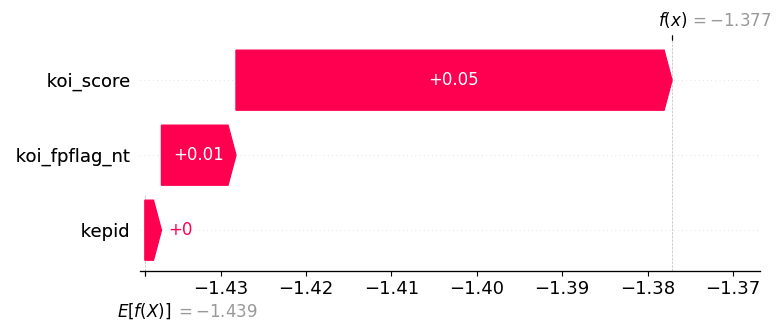

In [65]:
print(f"🔎 Local SHAP for sample {sample_idx}, predicted class: {pred_class_name}")
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[pred_class_idx],
    shap_values[pred_class_idx][sample_idx, :],
    feature_names=feature_names,
    features=sample_data
)
plt.show()

# Concatinated Dataset

In [67]:
df.to_csv("concatenated_exoplanet_data_preprocessed.csv", index=False)
print("Concatenated dataset saved as 'concatenated_exoplanet_data.csv'")

Concatenated dataset saved as 'concatenated_exoplanet_data.csv'
